<a href="https://colab.research.google.com/github/Abrar2652/Road-Friction-Forecasting/blob/master/Road_Friction_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authors: 
**Md. Abrar Jahin**

*   LinkedIn: https://www.linkedin.com/in/md-abrar-jahin-9a026018b
*   Facebook: https://www.facebook.com/
*   Github: https://github.com/Abrar2652
*   email: abrar.jahin.2652@gmail.com


**Andrii Krutsylo**

*  Website: https://krutsylo.neocities.org
*  email: krutsylo@airmail.cc

# Import Libraries and Packages

After importing libraries and packages, we start off by defining a function `transform_to_supervised` that creates desired **lag** *(24 hours in this case)* and **forecasting** features *(1 hour)* of our independent variables concatening with the dataframe and returns the final dataframe.


In [43]:
import os
import optuna
import pickle
import pandas as pd
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, accuracy_score, balanced_accuracy_score
import numpy as np


def transform_to_supervised(df,
                            previous_steps=1, 
                            forecast_steps=1,
                            dropnan=False):

    """
    https://gist.github.com/monocongo/6e0df19c9dd845f3f465a9a6ccfcef37
    
    
    Transforms a DataFrame containing time series data into a DataFrame
    containing data suitable for use as a supervised learning problem.
    
    Derived from code originally found at 
    https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    
    :param df: pandas DataFrame object containing columns of time series values
    :param previous_steps: the number of previous steps that will be included in the
                           output DataFrame corresponding to each input column
    :param forecast_steps: the number of forecast steps that will be included in the
                           output DataFrame corresponding to each input column
    :return Pandas DataFrame containing original columns, renamed <orig_name>(t), as well as
            columns for previous steps, <orig_name>(t-1) ... <orig_name>(t-n) and columns 
            for forecast steps, <orig_name>(t+1) ... <orig_name>(t+n)
    """
    
    # original column names
    col_names = df.columns
    
    # list of columns and corresponding names we'll build from 
    # the originals found in the input DataFrame
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    # Lag features
    for i in range(previous_steps, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for col_name in col_names]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecast_steps):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % col_name) for col_name in col_names]
        else:
            names += [('%s(t+%d)' % (col_name, i)) for col_name in col_names]

    # put all the columns together into a single aggregated DataFrame
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg


# Data Collection and Import data


The dataset has been collected from the **Smart Road - Winter Road Maintenance Challenge 2021** organized by *UiT The Arctic University of Norway* on Devpost.

Dataset download link: https://uitno.app.box.com/s/bch09z27weq0wpcv8dbbc18sxz6cycjt

After downloading the `smart_road_measurements.csv` file from the competition page, wehad added extra columns collecting data from the external resources authorized the organizers. The links of the external datasets are:

[1] Weather data https://pypi.org/project/wwo-hist/ 

[2] UV Index data https://pyowm.readthedocs.io/en/latest/v3/uv-api-usage-examples.html 

After merging these 3 files together based on the same dates, we finalized our main dataset `smart_road_measurements_new_d_weather.csv` on top of which we will build our model after preprocessing.

In [44]:
df = pd.read_csv("/content/smart_road_measurements_new_d_weather.csv", header=0)
df2 = df.copy()

In [45]:
df.head(15)

,Date,Time(+01:00),Friction,State,Ta,Tsurf,Water,Height,Distance,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,UV radiation
0,2021.02.16,07:11:19,0.33,6,-2.4,-6.07,0.0,118.0,0,-6,-11,0.0,8.0,2,27,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
1,2021.02.16,07:11:20,0.33,6,-2.4,-6.12,0.0,118.0,5,-6,-11,0.0,8.0,2,27,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
2,2021.02.16,07:11:21,0.33,6,-2.4,-6.17,0.0,118.0,5,-6,-11,0.0,8.0,2,27,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
3,2021.02.16,07:11:22,0.34,6,-2.4,-6.17,0.0,118.0,10,-6,-11,0.0,8.0,2,27,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
4,2021.02.16,07:11:23,0.33,6,-2.4,-6.17,0.0,118.0,14,-6,-11,0.0,8.0,2,27,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
5,2021.02.16,07:11:24,0.34,6,-2.4,-6.67,0.0,118.0,18,-6,-11,0.0,8.0,2,27,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
6,2021.02.16,07:11:25,0.34,6,-2.4,-6.77,0.0,118.0,22,-6,-11,0.0,8.0,2,27,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
7,2021.02.16,07:11:26,0.35,6,-2.4,-6.83,0.0,118.0,26,-6,-11,0.0,8.0,2,27,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
8,2021.02.16,07:11:27,0.35,6,-2.4,-6.97,0.0,117.0,30,-6,-11,0.0,8.0,2,27,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
9,2021.02.16,07:11:28,0.35,6,-2.4,-6.99,0.0,116.0,34,-6,-11,0.0,8.0,2,27,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2


# Exploratory Data Analysis

Our dataset contains 349613 rows and 29 columns

In [46]:
df.shape

(349613, 29)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349613 entries, 0 to 349612
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               349613 non-null  object 
 1   Time(+01:00)       349613 non-null  object 
 2   Friction           349613 non-null  float64
 3   State              349613 non-null  int64  
 4   Ta                 349613 non-null  float64
 5   Tsurf              349613 non-null  float64
 6   Water              349613 non-null  float64
 7   Height             347863 non-null  float64
 8   Distance           349613 non-null  int64  
 9   maxtempC           349613 non-null  int64  
 10  mintempC           349613 non-null  int64  
 11  totalSnow_cm       349613 non-null  float64
 12  sunHour            349613 non-null  float64
 13  uvIndex            349613 non-null  int64  
 14  moon_illumination  349613 non-null  int64  
 15  DewPointC          349613 non-null  int64  
 16  Fe

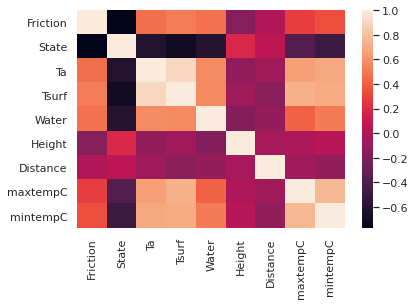

In [51]:
import numpy as np 
np.random.seed(0)
import seaborn as sns
sns.set_theme()
_ = sns.heatmap(df2.iloc[:,2:11].corr())

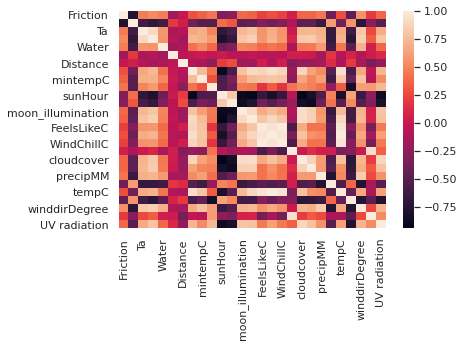

In [52]:
_ = sns.heatmap(df2.corr())

We want to predict Friction of the road by weather conditions. So,
this is a classification task. Every day the car drives on a new route.
This means that all 11 days we receive data on new road sections. So, the
only link between the road sections is the average weather conditions.


This can be achieved by filtering the rows on **Microsoft Excel** for each date and get the total distance covered (the last row on each date because the column is cumulative in nature)

**Max Distance traveled, Date**

42441, 16/02/2021

92311, 17/02/2021

150216, 18/02/2021

39007, 19/02/2021

71358, 22/02/2021

81999, 23/02/2021

55958, 24/02/2021

77315, 25/02/2021

55647, 26/02/2021

61534, 1/03/2021

12409, 2/03/2021


**Therefore, we can see from the above data that for all 11 days the car was driving at different routes**

* We drop the `Distance` because the condition of the road does not depend on how much the car has traveled before. We use this column to get the speed and slope of the road.

* This means that we are using normalized data + lag (time-series
classification with engineered features instead of time-series
classification with deep learning, because we have shallow data). 
We won't focus on any complicated models, just XGBClassifier to win.

* Now we need to define at what Friction the road is dangerous (label 0),
requires caution (label-1) and safe (label-2).

Ta, Tsurf, friction are **highly correlated** which has been shown in our pandas profiling 
https://krutsylo.neocities.org/SmartRoads/pandas3.html of the smart road dataset.

Yet we'll drop State, Height, Distance, Ta, Tsurf, Water, moon-illumination, uvIndex columns

In [50]:
df = df.drop("Height", axis=1) # contain N/A

df = df.drop("Distance", axis=1)
df = df.drop("State", axis=1)
df = df.drop("Ta", axis=1)
df = df.drop("Tsurf", axis=1)
df = df.drop("Water", axis=1)

df = df.drop("moon_illumination", axis=1)
df = df.drop("uvIndex", axis=1)
df.head()

,Date,Time(+01:00),Friction,maxtempC,mintempC,totalSnow_cm,sunHour,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,UV radiation
0,2021.02.16,07:11:19,0.33,-6,-11,0.0,8.0,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
1,2021.02.16,07:11:20,0.33,-6,-11,0.0,8.0,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
2,2021.02.16,07:11:21,0.33,-6,-11,0.0,8.0,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
3,2021.02.16,07:11:22,0.34,-6,-11,0.0,8.0,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2
4,2021.02.16,07:11:23,0.33,-6,-11,0.0,8.0,-15,-16,-9,-16,27,0,65,0.0,1020,-9,10,113,14,0.2


  We have grouped the data by calculating the mean of the rows in each hour based on the individual dates. For instance, if there are 8 rows for each hour, we calculated the mean of 8 rows and thus converted into a single row belonging to the distinct dates.

  We also avoided duplicates to reduce the noise in the data.

In [23]:
df['Time(+01:00)'] = pd.to_datetime(df['Time(+01:00)'], format='%H:%M:%S').dt.hour
df = df.groupby(['Date','Time(+01:00)']).mean()
df = df.drop_duplicates()
df.head()

Friction  maxtempC  ...  windspeedKmph  UV radiation
Date       Time(+01:00)                      ...                             
2021.02.16 7             0.359750        -6  ...             14           0.2
           8             0.379456        -6  ...             14           0.2
           9             0.374158        -6  ...             14           0.2
           10            0.377506        -6  ...             14           0.2
           11            0.450421        -6  ...             14           0.2

[5 rows x 19 columns]

Now we will work on the target feature that is `Friction` column to accomplish our objective since we want to perform a supervised machine learning model. Here we applied our knowledge of physics and research capabilities.

Icy: These roads typically have the lowest coefficient of friction. For drivers, this is the most dangerous surface to be on. The small coefficient of friction gives the driver the least amount of traction when accelerating, braking, or turning (which has angular acceleration). Icy roads have a frictional coefficient of around 0.1.

Wet: Roads wet with water have a coefficient of friction of around .4.  This is around 4 times higher than an icy road. Although these roads are much safer to drive on, there is still the possibility of hydroplaning. Hydroplaning occurs when there is standing or flowing water on the road (typically from rainfall) that causes a tire to lose contact with the road's surface. The treads are designed to allow water to fill the crevices so that contact may be maintained between the road and the tire. However, if there is too much water, this may not be achieved, and hydroplaning will occur. This is precisely the reason that racing slicks have such a high coefficient of friction on dry roads (about .9) and a much lower coefficient on wet roads (as low as .1).  

Dry: Roads without precipitation are considered optimal for driving conditions. They have the highest coefficient of friction, around 0.9, which creates the most traction. This allows corners, acceleration, and braking to reach higher values without loss of control. Oftentimes, if roads are not dry, races will be canceled due to the extreme dangers that a less than optimal frictional surface can pose. 

So, we'll take (0 <= friction < 0.5) as *dangerous*, and (0.5 < friction <= 1) as *safe*

In [24]:
bins = [0, 0.5, 1]
labels = [0, 1]
df["Friction"] = pd.cut(df["Friction"], bins, labels=labels)

#df = df.drop("Date", axis=1)
#df = df.drop("Time(+01:00)", axis=1)
df.head()

Friction  maxtempC  ...  windspeedKmph  UV radiation
Date       Time(+01:00)                     ...                             
2021.02.16 7                   0        -6  ...             14           0.2
           8                   0        -6  ...             14           0.2
           9                   0        -6  ...             14           0.2
           10                  0        -6  ...             14           0.2
           11                  0        -6  ...             14           0.2

[5 rows x 19 columns]

Now we'll perform lagging and forecasting feature columns by shifting simply using our pre-defined `transform_to_supervise` function.

In [25]:
df = transform_to_supervised(df, previous_steps=24, forecast_steps=1, dropnan=True)

Y = df.loc[:, "Friction(t)"].to_numpy()

cols = [c for c in df.columns if '(t)' not in c]
data=df[cols]

data['Friction'] = Y
data.to_csv('/content/test.csv')
data = data.values.tolist()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
df[cols].head()

Friction(t-24)  ...  UV radiation(t-1)
Date       Time(+01:00)                 ...                   
2021.02.18 11                        0  ...               0.21
           12                        0  ...               0.21
           13                        0  ...               0.21
           14                        0  ...               0.21
           15                        0  ...               0.21

[5 rows x 456 columns]

**Lag of 1 to 3 days**

In [114]:
lag = pd.read_csv('/content/lag(1-3)days.csv')
lag=lag.head(10)
lag

,Date,DewPointC(t-3),DewPointC(t-2),DewPointC(t-1),DewPointC,FeelsLikeC(t-3),FeelsLikeC(t-2),FeelsLikeC(t-1),FeelsLikeC,HeatIndexC(t-3),HeatIndexC(t-2),HeatIndexC(t-1),HeatIndexC,WindChillC(t-3),WindChillC(t-2),WindChillC(t-1),WindChillC,WindGustKmph(t-3),WindGustKmph(t-2),WindGustKmph(t-1),WindGustKmph,cloudcover(t-3),cloudcover(t-2),cloudcover(t-1),cloudcover,humidity(t-3),humidity(t-2),humidity(t-1),humidity,precipMM(t-3),precipMM(t-2),precipMM(t-1),precipMM,pressure(t-3),pressure(t-2),pressure(t-1),pressure,tempC(t-3),tempC(t-2),tempC(t-1),tempC,visibility(t-3),visibility(t-2),visibility(t-1),visibility,winddirDegree(t-3),winddirDegree(t-2),winddirDegree(t-1),winddirDegree,windspeedKmph(t-3),windspeedKmph(t-2),windspeedKmph(t-1),windspeedKmph
0,2021.02.16,NaN,NaN,-6.875000,-12.625000,NaN,NaN,-8.666667,-13.166667,NaN,NaN,-4.958333,-7.833333,NaN,NaN,-8.666667,-13.166667,NaN,NaN,13.125000,24.458333,NaN,NaN,77.875000,5.458333,NaN,NaN,87.000000,66.625000,NaN,NaN,0.316667,0.000000,NaN,NaN,1024.500000,1019.583333,NaN,NaN,-5.083333,-8.000000,NaN,NaN,5.916667,10.000000,NaN,NaN,159.291667,113.250000,NaN,NaN,8.333333,13.041667
1,2021.02.17,NaN,-6.875000,-12.625000,-15.291667,NaN,-8.666667,-13.166667,-8.875000,NaN,-4.958333,-7.833333,-5.708333,NaN,-8.666667,-13.166667,-8.875000,NaN,13.125000,24.458333,16.583333,NaN,77.875000,5.458333,6.666667,NaN,87.000000,66.625000,46.291667,NaN,0.316667,0.000000,0.000000,NaN,1024.500000,1019.583333,1015.875000,NaN,-5.083333,-8.000000,-5.833333,NaN,5.916667,10.000000,10.000000,NaN,159.291667,113.250000,129.625000,NaN,8.333333,13.041667,7.916667
2,2021.02.18,-6.875000,-12.625000,-15.291667,-17.750000,-8.666667,-13.166667,-8.875000,-13.166667,-4.958333,-7.833333,-5.708333,-9.375000,-8.666667,-13.166667,-8.875000,-13.166667,13.125000,24.458333,16.583333,17.791667,77.875000,5.458333,6.666667,21.666667,87.000000,66.625000,46.291667,49.875000,0.316667,0.000000,0.000000,0.000000,1024.500000,1019.583333,1015.875000,1012.458333,-5.083333,-8.000000,-5.833333,-10.083333,5.916667,10.000000,10.000000,10.000000,159.291667,113.250000,129.625000,99.833333,8.333333,13.041667,7.916667,8.666667
3,2021.02.19,-12.625000,-15.291667,-17.750000,-17.166667,-13.166667,-8.875000,-13.166667,-22.666667,-7.833333,-5.708333,-9.375000,-15.041667,-13.166667,-8.875000,-13.166667,-22.666667,24.458333,16.583333,17.791667,34.250000,5.458333,6.666667,21.666667,15.208333,66.625000,46.291667,49.875000,78.458333,0.000000,0.000000,0.000000,0.000000,1019.583333,1015.875000,1012.458333,1013.083333,-8.000000,-5.833333,-10.083333,-15.250000,10.000000,10.000000,10.000000,10.000000,113.250000,129.625000,99.833333,103.416667,13.041667,7.916667,8.666667,17.041667
4,2021.02.22,-15.291667,-17.750000,-17.166667,-6.250000,-8.875000,-13.166667,-22.666667,-9.875000,-5.708333,-9.375000,-15.041667,-4.791667,-8.875000,-13.166667,-22.666667,-9.875000,16.583333,17.791667,34.250000,25.000000,6.666667,21.666667,15.208333,83.333333,46.291667,49.875000,78.458333,88.041667,0.000000,0.000000,0.000000,0.295833,1015.875000,1012.458333,1013.083333,1016.500000,-5.833333,-10.083333,-15.250000,-4.875000,10.000000,10.000000,10.000000,5.333333,129.625000,99.833333,103.416667,126.333333,7.916667,8.666667,17.041667,13.041667
5,2021.02.23,-17.750000,-17.166667,-6.250000,-4.208333,-13.166667,-22.666667,-9.875000,-6.291667,-9.375000,-15.041667,-4.791667,-2.875000,-13.166667,-22.666667,-9.875000,-6.291667,17.791667,34.250000,25.000000,16.708333,21.666667,15.208333,83.333333,86.166667,49.875000,78.458333,88.041667,87.125000,0.000000,0.000000,0.295833,0.037500,1012.458333,1013.083333,1016.500000,1014.375000,-10.083333,-15.250000,-4.875000,-3.208333,10.000000,10.000000,5.333333,8.708333,99.833333,103.416667,126.333333,150.083333,8.666667,17.041667,13.041667,8.666667
6,2021.02.24,-17.166667,-6.250000,-4.208333,-2.208333,-22.666667,-9.875000,-6.291667,-5.250000,-15.041667,-4.791667,-2.875000,-1.541667,-22.666667,-9.875000,-6.291667,-5.250000,34.250000,25.000000,16.708333,22.208333,15.

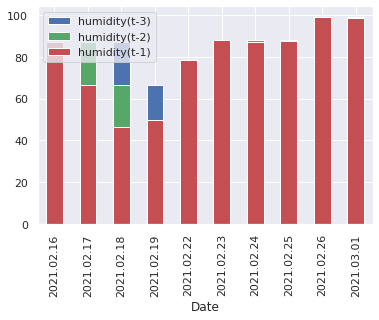

In [115]:
ax = lag.plot(x="Date", y="humidity(t-3)", kind="bar")
lag.plot(x="Date", y="humidity(t-2)", kind="bar", ax=ax, color="C2")
lag.plot(x="Date", y="humidity(t-1)", kind="bar", ax=ax, color="C3")

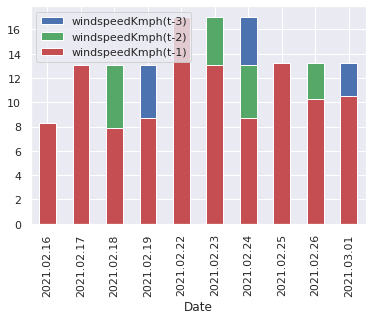

In [116]:
ax = lag.plot(x="Date", y="windspeedKmph(t-3)", kind="bar")
lag.plot(x="Date", y="windspeedKmph(t-2)", kind="bar", ax=ax, color="C2")
lag.plot(x="Date", y="windspeedKmph(t-1)", kind="bar", ax=ax, color="C3")

# Statistical Analysis

**Mean values of each column**

In [65]:
mean = pd.read_csv('/content/Mean.csv')
mean.head()

,Date,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2021.02.16,-12.625000,-13.166667,-7.833333,-13.166667,24.458333,5.458333,66.625000,0.000000,1019.583333,-8.000000,10.000000,113.250000,13.041667
1,2021.02.17,-15.291667,-8.875000,-5.708333,-8.875000,16.583333,6.666667,46.291667,0.000000,1015.875000,-5.833333,10.000000,129.625000,7.916667
2,2021.02.18,-17.750000,-13.166667,-9.375000,-13.166667,17.791667,21.666667,49.875000,0.000000,1012.458333,-10.083333,10.000000,99.833333,8.666667
3,2021.02.19,-17.166667,-22.666667,-15.041667,-22.666667,34.250000,15.208333,78.458333,0.000000,1013.083333,-15.250000,10.000000,103.416667,17.041667
4,2021.02.22,-6.250000,-9.875000,-4.791667,-9.875000,25.000000,83.333333,88.041667,0.295833,1016.500000,-4.875000,5.333333,126.333333,13.041667


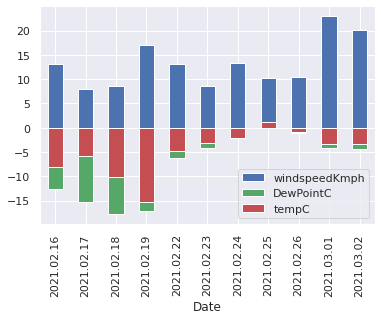

In [104]:
ax = mean.plot(x="Date", y="windspeedKmph", kind="bar")
mean.plot(x="Date", y="DewPointC", kind="bar", ax=ax, color="C2")
mean.plot(x="Date", y="tempC", kind="bar", ax=ax, color="C3")
#mean.plot(x="Date", y="HeatIndexC", kind="bar", ax=ax, color="C4")
#mean.plot(x="Date", y="humidity", kind="bar", ax=ax, color="C4")
#mean.plot(x="Date", y="pressure", kind="bar", ax=ax, color="C5")

plt.show()

In [77]:
mean.columns

Index(['Date', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph'],
      dtype='object')

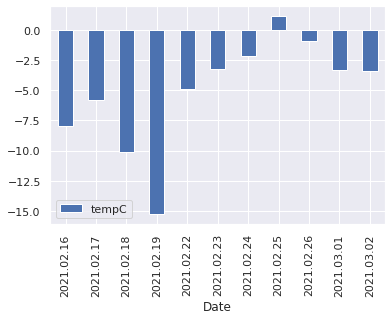

In [84]:
mean.plot(x="Date", y=['tempC'], kind="bar")

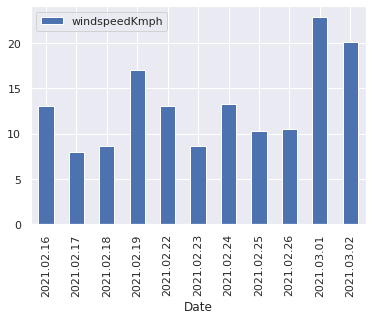

In [85]:
mean.plot(x="Date", y=['windspeedKmph'], kind="bar")

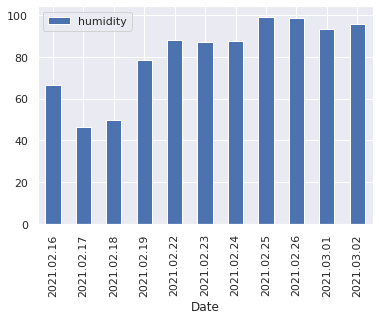

In [86]:
mean.plot(x="Date", y=['humidity'], kind="bar")

**Standard Deviations of each column**

In [106]:
stdev=pd.read_csv('/content/Stdev.csv')
stdev

,Date,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2021.02.16,-16,-16,-10,-16,21,0,59,0.0,1018,-11,10,109,11
1,2021.02.17,-20,-12,-7,-12,8,3,33,0.0,1014,-8,10,117,4
2,2021.02.18,-22,-18,-15,-18,8,6,30,0.0,1012,-18,10,93,4
3,2021.02.19,-20,-26,-20,-26,26,3,76,0.0,1012,-22,10,95,14
4,2021.02.22,-13,-20,-14,-20,18,70,82,0.0,1015,-15,2,117,12
5,2021.02.23,-7,-10,-5,-10,8,58,79,0.0,1013,-6,5,132,5
6,2021.02.24,-4,-8,-5,-8,18,66,77,0.0,991,-8,5,107,11
7,2021.02.25,1,-3,1,-3,6,100,98,1.2,990,-1,4,180,4
8,2021.02.26,-6,-11,-6,-11,12,97,95,0.4,994,-6,2,258,8
9,2021.03.01,-7,-13,-6,-13,30,89,86,0.6,1002,-6,1,253,17


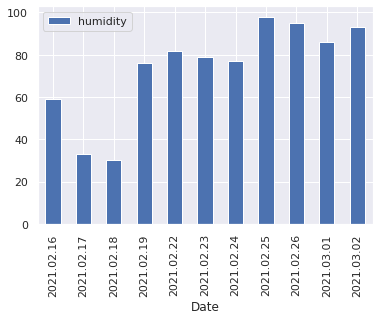

In [107]:
stdev.plot(x="Date", y=['humidity'], kind="bar")

**Minimum values of each column**

In [57]:
pd.read_csv('/content/Min.csv')

,Date,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2021.02.16,-16,-16,-10,-16,21,0,59,0.0,1018,-11,10,109,11
1,2021.02.17,-20,-12,-7,-12,8,3,33,0.0,1014,-8,10,117,4
2,2021.02.18,-22,-18,-15,-18,8,6,30,0.0,1012,-18,10,93,4
3,2021.02.19,-20,-26,-20,-26,26,3,76,0.0,1012,-22,10,95,14
4,2021.02.22,-13,-20,-14,-20,18,70,82,0.0,1015,-15,2,117,12
5,2021.02.23,-7,-10,-5,-10,8,58,79,0.0,1013,-6,5,132,5
6,2021.02.24,-4,-8,-5,-8,18,66,77,0.0,991,-8,5,107,11
7,2021.02.25,1,-3,1,-3,6,100,98,1.2,990,-1,4,180,4
8,2021.02.26,-6,-11,-6,-11,12,97,95,0.4,994,-6,2,258,8
9,2021.03.01,-7,-13,-6,-13,30,89,86,0.6,1002,-6,1,253,17


**Maximum values of each column**

In [58]:
pd.read_csv('/content/Max.csv')

,Date,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2021.02.16,-10,-11,-6,-11,28,22,70,0.0,1021,-6,10,117,14
1,2021.02.17,-13,-5,-4,-5,27,11,57,0.0,1019,-4,10,148,13
2,2021.02.18,-14,-8,-6,-8,27,63,74,0.0,1014,-7,10,108,13
3,2021.02.19,-14,-18,-13,-18,39,57,81,0.0,1014,-13,10,118,19
4,2021.02.22,-3,-4,0,-4,35,100,96,0.8,1017,0,10,139,17
5,2021.02.23,-2,-3,-1,-3,26,99,95,0.4,1016,-1,10,168,13
6,2021.02.24,1,-4,0,-4,29,100,98,3.8,1013,0,10,197,15
7,2021.02.25,2,0,2,0,25,100,100,4.2,994,2,7,312,17
8,2021.02.26,1,-2,1,-2,26,100,99,5.6,1019,1,3,299,13
9,2021.03.01,-1,-5,0,-5,51,100,98,3.3,1008,0,7,265,28


**Median values of each column**

In [94]:
med = pd.read_csv('/content/Median.csv')
med

,Date,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2021.02.16,-12.5,-13.0,-8.0,-13.0,24.5,4.0,67.0,0.00,1020.0,-8.0,10.0,113.0,13.0
1,2021.02.17,-14.0,-9.0,-6.0,-9.0,11.5,7.0,46.0,0.00,1016.0,-6.0,10.0,126.0,6.0
2,2021.02.18,-16.0,-12.0,-8.0,-12.0,17.0,12.5,53.0,0.00,1012.0,-8.0,10.0,100.0,8.0
3,2021.02.19,-17.0,-23.0,-15.0,-23.0,35.0,8.0,78.0,0.00,1013.0,-15.0,10.0,101.5,17.0
4,2021.02.22,-5.5,-9.0,-4.0,-9.0,26.0,81.5,87.0,0.30,1017.0,-4.0,6.0,126.5,12.0
5,2021.02.23,-3.0,-6.0,-3.0,-6.0,16.5,89.0,86.0,0.00,1014.0,-4.0,10.0,148.5,9.0
6,2021.02.24,-3.0,-5.0,-1.0,-5.0,21.0,100.0,87.5,0.25,1000.5,-1.5,9.0,138.5,13.0
7,2021.02.25,1.0,-1.5,1.0,-1.5,13.5,100.0,99.0,2.30,992.0,1.0,6.0,276.5,9.5
8,2021.02.26,-1.0,-4.0,0.0,-4.0,14.0,100.0,99.0,1.05,1006.0,0.0,2.0,274.5,11.0
9,2021.03.01,-5.0,-11.0,-4.0,-11.0,42.5,96.0,92.5,1.30,1004.0,-4.0,2.5,259.0,23.0


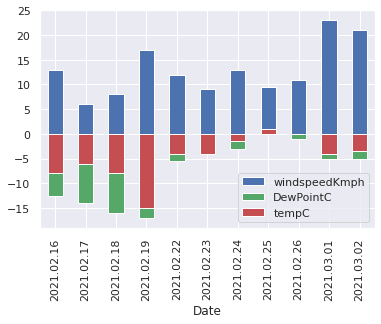

In [103]:
ax = med.plot(x="Date", y="windspeedKmph", kind="bar")
med.plot(x="Date", y="DewPointC", kind="bar", ax=ax, color="C2")
med.plot(x="Date", y="tempC", kind="bar", ax=ax, color="C3")
#mean.plot(x="Date", y="HeatIndexC", kind="bar", ax=ax, color="C4")
#med.plot(x="Date", y="humidity", kind="bar", ax=ax, color="C4")
#med.plot(x="Date", y="pressure", kind="bar", ax=ax, color="C5")

**Quartile-1 values of each column**

25% data are less than these values

In [60]:
pd.read_csv('/content/Q1.csv')

,Date,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2021.02.16,-13.25,-14.00,-9.00,-14.00,23.00,0.00,65.00,0.000,1019.00,-9.00,10.00,112.00,13.00
1,2021.02.17,-16.25,-11.00,-7.00,-11.00,9.00,5.00,43.00,0.000,1015.00,-7.00,10.00,118.75,4.00
2,2021.02.18,-20.25,-15.00,-11.00,-15.00,15.00,10.00,31.75,0.000,1012.00,-12.25,10.00,97.00,7.00
3,2021.02.19,-18.00,-24.00,-15.25,-24.00,32.75,6.00,77.00,0.000,1013.00,-16.00,10.00,96.00,16.00
4,2021.02.22,-8.25,-13.25,-7.25,-13.25,20.75,75.50,85.00,0.100,1016.00,-7.25,2.00,122.75,12.00
5,2021.02.23,-7.00,-8.00,-4.00,-8.00,12.00,82.75,81.75,0.000,1014.00,-4.00,7.75,144.00,7.00
6,2021.02.24,-3.25,-6.00,-2.00,-6.00,19.75,88.75,80.00,0.000,994.00,-3.00,5.00,122.00,12.00
7,2021.02.25,1.00,-3.00,1.00,-3.00,7.75,100.00,99.00,1.975,990.00,1.00,6.00,248.75,6.00
8,2021.02.26,-1.25,-5.25,-1.25,-5.25,13.00,100.00,99.00,0.775,998.75,-1.25,2.00,264.00,9.75
9,2021.03.01,-6.00,-12.00,-5.00,-12.00,35.00,93.00,89.00,0.975,1003.00,-5.00,2.00,257.00,22.00


**Quartile-3 values of each column**

75% data are less than these values

In [62]:
pd.read_csv('/content/Q3.csv')

,Date,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2021.02.16,-11.00,-12.00,-7.00,-12.00,26.00,7.75,69.00,0.000,1020.00,-7.00,10,115.25,14.00
1,2021.02.17,-14.00,-7.75,-5.00,-7.75,26.00,8.25,50.25,0.000,1016.25,-5.00,10,141.25,13.00
2,2021.02.18,-16.00,-11.75,-7.00,-11.75,21.50,29.50,64.00,0.000,1013.00,-7.00,10,102.00,10.25
3,2021.02.19,-16.00,-21.75,-13.75,-21.75,36.00,17.75,80.00,0.000,1013.25,-13.75,10,109.25,18.25
4,2021.02.22,-3.75,-6.00,-1.75,-6.00,27.25,91.25,92.00,0.425,1017.00,-1.75,8,129.25,14.00
5,2021.02.23,-2.00,-4.75,-2.00,-4.75,20.50,93.25,93.00,0.000,1015.00,-2.00,10,158.25,10.00
6,2021.02.24,-1.75,-4.75,-0.75,-4.75,24.25,100.00,95.50,1.350,1006.50,-0.75,10,151.25,14.00
7,2021.02.25,1.25,0.00,1.25,0.00,22.25,100.00,100.00,2.975,993.00,1.25,7,296.00,14.25
8,2021.02.26,0.00,-3.00,0.25,-3.00,15.25,100.00,99.00,1.700,1013.25,0.25,2,278.25,11.00
9,2021.03.01,-2.75,-7.75,-1.75,-7.75,49.00,100.00,98.00,1.650,1005.25,-1.75,5,261.00,24.00


**Kurtosis values of each column**


In [90]:
krt = pd.read_csv('/content/Kurtosis.csv')
krt

,Date,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2021.02.16,-0.533679,-0.329786,-1.261969,-0.329786,-0.810169,0.562268,0.882804,NaN,-0.537118,-1.187185,NaN,-0.651845,0.307322
1,2021.02.17,-0.156483,-0.857302,-1.169816,-0.857302,-1.953784,-0.838175,0.062562,NaN,0.371681,-1.151494,NaN,-1.754513,-1.902038
2,2021.02.18,-1.416625,-0.799192,-0.757343,-0.799192,-0.492789,0.360928,-1.677883,NaN,-0.114172,-0.370874,NaN,-0.457923,-0.417035
3,2021.02.19,-0.277862,-0.315661,0.466853,-0.315661,0.994396,1.940711,-1.446053,NaN,-0.424240,1.696292,NaN,-1.070540,-0.827527
4,2021.02.22,-0.534317,-0.573204,-0.057326,-0.573204,-0.780388,-1.174976,-1.083902,-0.679238,-0.158495,0.368871,-1.869970948,-0.206633,1.167653
5,2021.02.23,-1.666446,-1.103563,-1.109776,-1.103563,-0.963271,1.227880,-1.776409,8.520248,0.126171,-1.216828,-0.54550424,-0.628107,-0.747762
6,2021.02.24,-0.467994,0.718575,0.431601,0.718575,-0.533456,1.013284,-1.630926,0.745217,-1.328114,0.867099,-1.92742611,-0.272704,-1.123266
7,2021.02.25,1.841379,0.366071,1.841379,0.366071,-1.672208,25.000000,24.940672,-0.793899,24.997172,2.637735,4.293262621,9.807289,-1.581365
8,2021.02.26,0.794306,1.007814,0.862517,1.007814,1.157910,4.163657,11.677587,9.096371,-1.434763,0.862517,9.123966942,0.529117,-0.305705
9,2021.03.01,-1.145131,-1.162153,-1.114753,-1.162153,-1.472484,-1.288554,-1.806529,2.524619,-0.666306,-1.139070,-0.995033766,-0.442172,1.963088


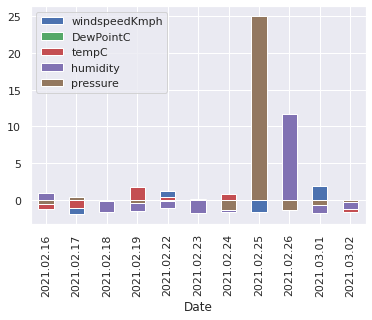

In [101]:
ax = krt.plot(x="Date", y="windspeedKmph", kind="bar")
krt.plot(x="Date", y="DewPointC", kind="bar", ax=ax, color="C2")
krt.plot(x="Date", y="tempC", kind="bar", ax=ax, color="C3")
krt.plot(x="Date", y="humidity", kind="bar", ax=ax, color="C4")
krt.plot(x="Date", y="pressure", kind="bar", ax=ax, color="C5")

plt.show()

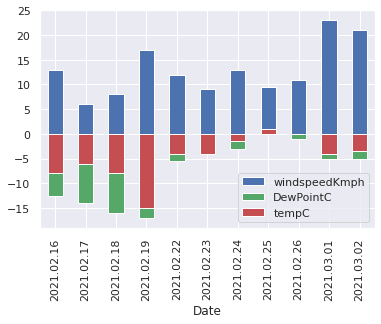

In [105]:
ax = med.plot(x="Date", y="windspeedKmph", kind="bar")
med.plot(x="Date", y="DewPointC", kind="bar", ax=ax, color="C2")
med.plot(x="Date", y="tempC", kind="bar", ax=ax, color="C3")

**Skewness values of each column**


In [93]:
skw=pd.read_csv('/content/Skewness.csv')
skw

,Date,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2021.02.16,-0.467567,-0.714413,-0.105969,-0.714413,-0.217241,1.201579,-0.928002,NaN,-0.442597,-0.224721,NaN,0.219575,-0.847487
1,2021.02.17,-1.072579,0.336856,0.254766,0.336856,0.266135,0.191835,-0.061076,NaN,0.820977,0.141968,NaN,0.293102,0.261574
2,2021.02.18,-0.450174,-0.183492,-0.627521,-0.183492,0.309021,1.199132,-0.087316,NaN,0.873068,-0.963440,NaN,-0.099599,0.433610
3,2021.02.19,0.160960,0.527283,-1.093804,0.527283,-1.173962,1.672922,0.074003,NaN,-0.080121,-1.427851,NaN,0.546657,-0.350995
4,2021.02.22,-0.764065,-0.730865,-0.914180,-0.730865,0.214608,0.278739,0.286287,0.453421,-1.198510,-1.046806,0.024403951,0.299184,1.387949
5,2021.02.23,-0.371272,0.110491,0.140984,0.110491,0.175504,-1.319644,0.011990,2.882551,0.690896,0.152368,-0.869145464,0.225103,-0.047893
6,2021.02.24,0.824710,-0.744205,-0.827806,-0.744205,0.707231,-1.488540,0.039961,1.405591,0.237356,-1.120812,-0.281855629,0.743278,-0.114980
7,2021.02.25,1.584456,0.719903,1.584456,0.719903,0.118163,-5.000000,-4.991446,0.398908,-4.999592,-0.365955,-1.748932273,-2.752590,0.109622
8,2021.02.26,-1.225706,-1.439720,-1.231829,-1.439720,1.564738,-2.215633,-3.309750,2.688913,0.007760,-1.231829,3.219960287,0.536353,-0.264291
9,2021.03.01,0.536174,0.610295,0.597052,0.610295,-0.282198,-0.284675,-0.058178,1.381475,0.719840,0.487355,0.565475194,0.229592,-0.237815


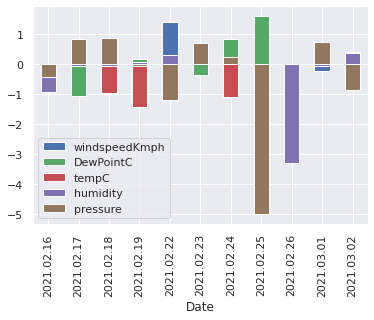

In [102]:
ax = skw.plot(x="Date", y="windspeedKmph", kind="bar")
skw.plot(x="Date", y="DewPointC", kind="bar", ax=ax, color="C2")
skw.plot(x="Date", y="tempC", kind="bar", ax=ax, color="C3")
skw.plot(x="Date", y="humidity", kind="bar", ax=ax, color="C4")
skw.plot(x="Date", y="pressure", kind="bar", ax=ax, color="C5")

plt.show()

# Model Building, Training and Prediction

In [31]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    print(n_test)
    data = np.array(data)
    return data[:-n_test, :], data[-n_test:, :]
    
# walk-forward validation for univariate data
def walk_forward_validation(params, data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(params, history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = balanced_accuracy_score(test[:, -1], predictions)
	return error, test[:, -1], predictions

# fit an xgboost model and make a one step prediction
def xgboost_forecast(params, train, testX):
	# transform list into array
	train = np.array(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBClassifier(**params)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.array([testX]))
	return yhat[0]
    
def objective(trial: Trial, data) -> float:
    params = {
        "booster": "gbtree",
        #"tree_method": "gpu_hist",
        "n_estimators": trial.suggest_int("n_estimators", 0, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 5),
        "gamma": trial.suggest_int("gamma", 0, 5),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
        "colsample_bytree": trial.suggest_discrete_uniform(
            "colsample_bytree", 0.1, 1, 0.01
        ),
        "nthread": -1,
        "use_label_encoder": False,
        "eval_metric": "logloss"
    }
    
    mae, y, yhat = walk_forward_validation(params, data, 20)
    
    return mae


if not os.path.exists('output'):
    os.makedirs('output')
        
study = optuna.create_study(
    direction="maximize", 
    sampler=TPESampler(seed=1337),
    study_name="res",
    storage="sqlite:///output/res.db",
    load_if_exists=True
    )
study.optimize(
    lambda trial: objective(trial, data), 
    n_trials=50, 
    show_progress_bar=True
    )
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df.to_csv("/content/res.csv", sep="\t")
print(study.best_trial)


[I 2021-03-28 11:15:04,669] Using an existing study with name 'res' instead of creating a new one.
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



20
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=0.0, predicted=1.0
>expected=0.0, predicted=0.0
>expected=1.0, predicted=0.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=0.0, predicted=1.0
>expected=0.0, predicted=1.0
>expected=0.0, predicted=0.0
[I 2021-03-28 11:15:12,312] Trial 50 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 948, 'max_depth': 9, 'reg_alpha': 1, 'reg_lambda': 4, 'min_child_weight': 3, 'gamma': 0, 'learning_rate': 0.23618847306152302, 'colsample_bytree': 0.48}. Best is trial 10 with value: 0.7666666666666666.
20
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0, predicted=1.0
>expected=1.0,

# Model Evaluation

Our model's Weighted accuracy is 0.7666666666666666 or **~76.67%**.
Now our model can forecast the friction and will label it as **'0' if dangerous** and **'1' if safe** for driving.